## Packages

In [3]:
import os.path as osp
from pathlib import Path
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import pandas as pd
import librosa
import math

from IPython.display import Audio
import librosa.display

## Arguments & User Defined Functions

In [4]:
min_words = 40
wavs_dir = "../outputs/wavs/"
target_sr = 16000
transcripts_path = "../outputs/all_transcripts.csv"
transcripts = pd.read_csv(transcripts_path)
print(transcripts.shape)

(565, 10)


In [5]:
def play_audio(signal, rate):
    return Audio(data=signal, rate=rate)

## Collect All Transcripts

In [6]:
wavs = [path for path in Path(wavs_dir).rglob("*.wav")]
print("WAV Files:", len(wavs))

WAV Files: 5


In [7]:
data = (
    transcripts.loc[
        (transcripts["word_count"] >= min_words)
        & (transcripts["speaker_role"] == "scotus_justice")
    ]
    .copy()
    .reset_index(drop=True)
)

print(data.shape)
data["start_idx"] = np.floor(data["start"] * target_sr).astype(int)
data["end_idx"] = np.ceil(data["end"] * target_sr).astype(int)


(177, 10)


In [8]:
a_sample = data.sample(n=5).reset_index(drop=True)
a_sample

file  line     start       end            speaker    speaker_role  \
0   12-138    20   590.610   622.231  Anthony_M_Kennedy  scotus_justice   
1  12-1038   181  2903.389  2920.461     Antonin_Scalia  scotus_justice   
2   12-515    19   283.216   302.127        Elena_Kagan  scotus_justice   
3   12-682   203  3646.224  3668.773   Stephen_G_Breyer  scotus_justice   
4  12-1036   130  2174.641  2193.205        Elena_Kagan  scotus_justice   

   word_count  duration                                               text  \
0          77    31.621  Well, then, let me just make clear where we ar...   
1          52    17.072  But not because it has anything to do with the...   
2          55    18.911  I'm sorry. Could you explain that? Because I t...   
3          58    22.549  You come -- now, suppose you take that and say...   
4          65    18.564  --the judge is going to say: You have 100 clai...   

   year  start_idx   end_idx  
0    12    9449760   9955696  
1    12   46454224  46727376  
2    12    4531456   4834032  
3    12   58339584  58700368  
4    12   34794256  35091280

## Listen to Audio

In [9]:
sample_1 = dict(a_sample.iloc[0])
wav_file, wav_sr = librosa.load(
    path=osp.join(wavs_dir, f"{sample_1['file']}.wav"),
    sr=librosa.core.get_samplerate(osp.join(wavs_dir, f"{sample_1['file']}.wav")),
)

print("Speaker:", sample_1["speaker"])
print("File - Line", sample_1["file"], "-", sample_1["line"])
print("Duration:", sample_1["duration"])
print("Text:", sample_1["text"])
start_idx = math.floor(wav_sr * sample_1["start"])
end_idx = math.ceil(wav_sr * sample_1["end"])
clip = wav_file[start_idx:end_idx]
play_audio(clip, wav_sr)

Speaker: Anthony_M_Kennedy
File - Line 12-138 - 20
Duration: 31.621
Text: Well, then, let me just make clear where we are. Suppose we, or at least I, were to conclude that the court of appeals was right, that it is for the Judicial Branch to decide whether there is an arbitration agreement and duty to arbitrate. Then I were to further conclude that, given Argentina's position, they have waived the judicial requirement and that this arbitration should proceed. I can't reach that second question because it wasn't raised.


C:\Users\yagne\.conda\envs\grandstanding\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


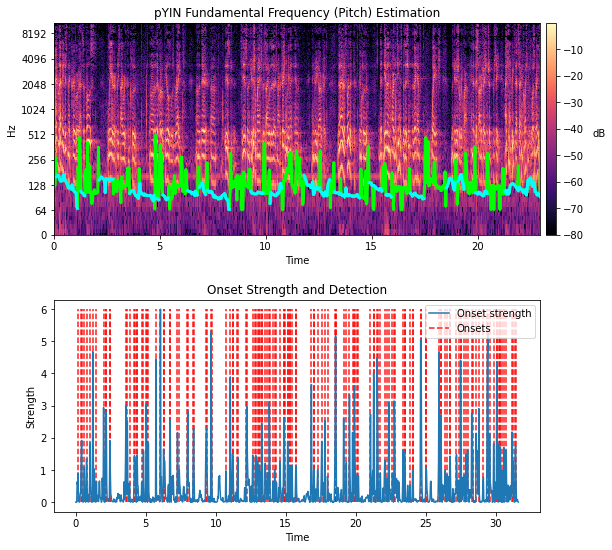

In [10]:
# Pitch
f0, voiced_flag, voiced_probs = librosa.pyin(
    clip, fmin=librosa.note_to_hz("C2"), fmax=librosa.note_to_hz("C5"), sr=wav_sr
)
times = librosa.times_like(f0)
D = librosa.amplitude_to_db(np.abs(librosa.stft(clip)), ref=np.max)
yin_f0 = librosa.yin(
    clip, fmin=librosa.note_to_hz("C2"), fmax=librosa.note_to_hz("C5"), sr=wav_sr
)

# Onset
o_env = librosa.onset.onset_strength(clip, sr=wav_sr, max_size=10)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=wav_sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=wav_sr)

spec_o_env = librosa.onset.onset_strength(clip, sr=wav_sr, max_size=1)
spec_times = librosa.frames_to_time(np.arange(len(spec_o_env)), sr=wav_sr)
spec_onset_frames = librosa.onset.onset_detect(onset_envelope=spec_o_env, sr=wav_sr)


# Plot
D = np.abs(librosa.stft(clip))


fig = plt.figure(figsize=(9, 9))
ax1 = plt.subplot(111)
im1 = librosa.display.specshow(
    librosa.amplitude_to_db(D, ref=np.max),
    x_axis="time",
    y_axis="log",
    ax=ax1,
    label="_nolegend_",
)
ax1.set(title="pYIN Fundamental Frequency (Pitch) Estimation")
(yin_f0_plot,) = ax1.plot(times, yin_f0, color="lime", label="f0 (Pitch)", linewidth=3)

(f0_plot,) = ax1.plot(times, f0, color="cyan", label="f0 (Pitch)", linewidth=3)

# ax1.legend(handles=[f0_plot])

divider = make_axes_locatable(ax1)
ax2 = divider.append_axes("bottom", size="100%", pad=0.9)
cax = divider.append_axes("right", size="2%", pad=0.08)
cb = plt.colorbar(im1, ax=ax1, cax=cax)
cax.get_yaxis().labelpad = 15
cax.set_ylabel("dB", rotation=0)

ax2.set(xlabel="Time", ylabel="Strength", title="Onset Strength and Detection")
ax2.plot(times, o_env, label="Onset strength")
ax2.vlines(
    times[onset_frames],
    0,
    o_env.max(),
    color="r",
    alpha=0.9,
    linestyle="--",
    label="Onsets",
)
ax2.legend()

Text(0.5, 1.0, 'Fundamental Frequency Estimates')

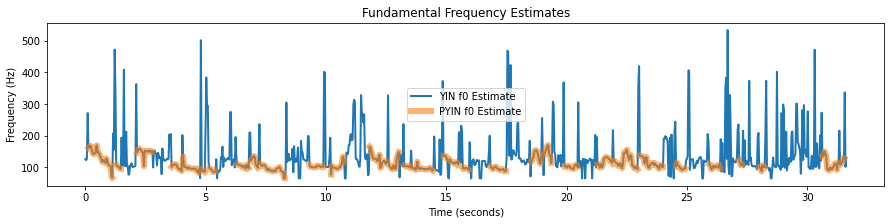

In [11]:
(yin_f0_plot,) = ax1.plot(times, yin_f0, color="lime", label="f0 (Pitch)", linewidth=3)
(f0_plot,) = ax1.plot(
    times,
    f0,
    color="cyan",
    label="f0 (Pitch)",
    linewidth=3,
)

plt.figure(figsize=(15, 3))
plt.plot(times, yin_f0, label="YIN f0 Estimate", linewidth=2)
plt.plot(times, f0, label="PYIN f0 Estimate", linewidth=6, alpha=0.6)
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.legend()
plt.title("Fundamental Frequency Estimates")

In [12]:
sample_1 = dict(a_sample.iloc[1])
wav_file, wav_sr = librosa.load(
    path=osp.join(wavs_dir, f"{sample_1['file']}.wav"),
    sr=librosa.core.get_samplerate(osp.join(wavs_dir, f"{sample_1['file']}.wav")),
)

print("Speaker:", sample_1["speaker"])
print("File - Line", sample_1["file"], "-", sample_1["line"])
print("Duration:", sample_1["duration"])
print("Text:", sample_1["text"])
start_idx = math.floor(wav_sr * sample_1["start"])
end_idx = math.ceil(wav_sr * sample_1["end"])
clip = wav_file[start_idx:end_idx]
play_audio(clip, wav_sr)

Speaker: Antonin_Scalia
File - Line 12-1038 - 181
Duration: 17.072
Text: But not because it has anything to do with the scope of authority of the government. It's what the government can do. I -- I don't know how to read that, that text, in such a way that it will avoid all First Amendment problems. There is no way to do that.


C:\Users\yagne\.conda\envs\grandstanding\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


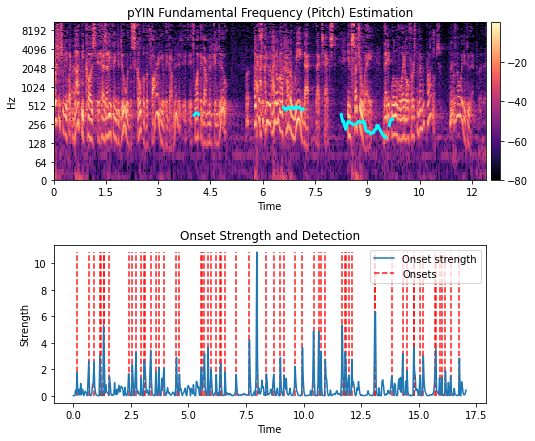

In [13]:
# Pitch
f0, voiced_flag, voiced_probs = librosa.pyin(
    clip, fmin=librosa.note_to_hz("C2"), fmax=librosa.note_to_hz("C5")
)
times = librosa.times_like(f0)
D = librosa.amplitude_to_db(np.abs(librosa.stft(clip)), ref=np.max)

# Onset
o_env = librosa.onset.onset_strength(clip, sr=wav_sr, max_size=10)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=wav_sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=wav_sr)


# Plot
D = np.abs(librosa.stft(clip))


fig = plt.figure(figsize=(8, 7))
ax1 = plt.subplot(111)
im1 = librosa.display.specshow(
    librosa.amplitude_to_db(D, ref=np.max),
    x_axis="time",
    y_axis="log",
    ax=ax1,
    label="_nolegend_",
)
ax1.set(title="pYIN Fundamental Frequency (Pitch) Estimation")
(f0_plot,) = ax1.plot(times, f0, color="cyan", label="f0 (Pitch)", linewidth=3)
# ax1.legend(handles=[f0_plot])

divider = make_axes_locatable(ax1)
ax2 = divider.append_axes("bottom", size="100%", pad=0.9)
cax = divider.append_axes("right", size="2%", pad=0.08)
cb = plt.colorbar(im1, ax=ax1, cax=cax)

ax2.set(xlabel="Time", ylabel="Strength", title="Onset Strength and Detection")
ax2.plot(times, o_env, label="Onset strength")
ax2.vlines(
    times[onset_frames],
    0,
    o_env.max(),
    color="r",
    alpha=0.9,
    linestyle="--",
    label="Onsets",
)
ax2.legend()

In [14]:
sample_1 = dict(a_sample.iloc[2])
wav_file, wav_sr = librosa.load(
    path=osp.join(wavs_dir, f"{sample_1['file']}.wav"),
    sr=librosa.core.get_samplerate(osp.join(wavs_dir, f"{sample_1['file']}.wav")),
)

print("Speaker:", sample_1["speaker"])
print("File - Line", sample_1["file"], "-", sample_1["line"])
print("Duration:", sample_1["duration"])
print("Text:", sample_1["text"])
start_idx = math.floor(wav_sr * sample_1["start"])
end_idx = math.ceil(wav_sr * sample_1["end"])
clip = wav_file[start_idx:end_idx]
play_audio(clip, wav_sr)

Speaker: Elena_Kagan
File - Line 12-515 - 19
Duration: 18.911
Text: I'm sorry. Could you explain that? Because I thought that the purpose -- that the whole point of the C&L Enterprises case is to say that when a tribe agrees to arbitration, it has waived its sovereign immunity for that purpose in that proceeding. Are you saying that there was something special in this agreement?


C:\Users\yagne\.conda\envs\grandstanding\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


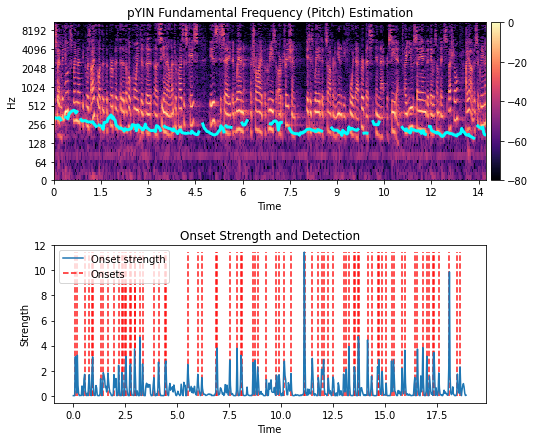

In [15]:
# Pitch
f0, voiced_flag, voiced_probs = librosa.pyin(
    clip, fmin=librosa.note_to_hz("C2"), fmax=librosa.note_to_hz("C5")
)
times = librosa.times_like(f0)
D = librosa.amplitude_to_db(np.abs(librosa.stft(clip)), ref=np.max)

# Onset
o_env = librosa.onset.onset_strength(clip, sr=wav_sr, max_size=10)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=wav_sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=wav_sr)


# Plot
D = np.abs(librosa.stft(clip))


fig = plt.figure(figsize=(8, 7))
ax1 = plt.subplot(111)
im1 = librosa.display.specshow(
    librosa.amplitude_to_db(D, ref=np.max),
    x_axis="time",
    y_axis="log",
    ax=ax1,
    label="_nolegend_",
)
ax1.set(title="pYIN Fundamental Frequency (Pitch) Estimation")
(f0_plot,) = ax1.plot(times, f0, color="cyan", label="f0 (Pitch)", linewidth=3)
# ax1.legend(handles=[f0_plot])

divider = make_axes_locatable(ax1)
ax2 = divider.append_axes("bottom", size="100%", pad=0.9)
cax = divider.append_axes("right", size="2%", pad=0.08)
cb = plt.colorbar(im1, ax=ax1, cax=cax)

ax2.set(xlabel="Time", ylabel="Strength", title="Onset Strength and Detection")
ax2.plot(times, o_env, label="Onset strength")
ax2.vlines(
    times[onset_frames],
    0,
    o_env.max(),
    color="r",
    alpha=0.9,
    linestyle="--",
    label="Onsets",
)
ax2.legend()

In [16]:
sample_1 = dict(a_sample.iloc[3])
wav_file, wav_sr = librosa.load(
    path=osp.join(wavs_dir, f"{sample_1['file']}.wav"),
    sr=librosa.core.get_samplerate(osp.join(wavs_dir, f"{sample_1['file']}.wav")),
)

print("Speaker:", sample_1["speaker"])
print("File - Line", sample_1["file"], "-", sample_1["line"])
print("Duration:", sample_1["duration"])
print("Text:", sample_1["text"])
start_idx = math.floor(wav_sr * sample_1["start"])
end_idx = math.ceil(wav_sr * sample_1["end"])
clip = wav_file[start_idx:end_idx]
play_audio(clip, wav_sr)

Speaker: Stephen_G_Breyer
File - Line 12-682 - 203
Duration: 22.549
Text: You come -- now, suppose you take that and say, all right, it was meant in context; but the context includes constitutional amendments because with the constitutional amendment you are restructuring. Now you would lose on that theory; but there would be a limitation on the extent to which the people have the right to move powers around.


C:\Users\yagne\.conda\envs\grandstanding\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


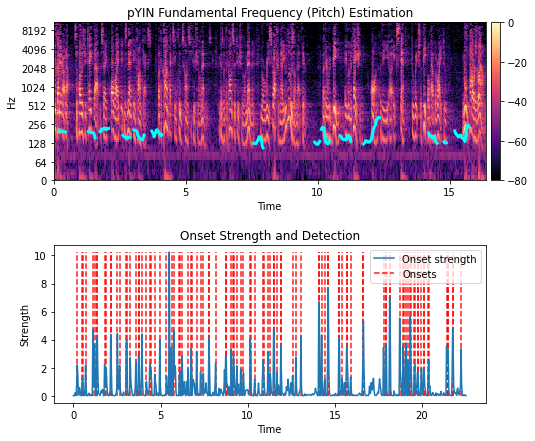

In [17]:
# Pitch
f0, voiced_flag, voiced_probs = librosa.pyin(
    clip, fmin=librosa.note_to_hz("C2"), fmax=librosa.note_to_hz("C5")
)
times = librosa.times_like(f0)
D = librosa.amplitude_to_db(np.abs(librosa.stft(clip)), ref=np.max)

# Onset
o_env = librosa.onset.onset_strength(clip, sr=wav_sr, max_size=10)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=wav_sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=wav_sr)


# Plot
D = np.abs(librosa.stft(clip))


fig = plt.figure(figsize=(8, 7))
ax1 = plt.subplot(111)
im1 = librosa.display.specshow(
    librosa.amplitude_to_db(D, ref=np.max),
    x_axis="time",
    y_axis="log",
    ax=ax1,
    label="_nolegend_",
)
ax1.set(title="pYIN Fundamental Frequency (Pitch) Estimation")
(f0_plot,) = ax1.plot(times, f0, color="cyan", label="f0 (Pitch)", linewidth=3)

divider = make_axes_locatable(ax1)
ax2 = divider.append_axes("bottom", size="100%", pad=0.9)
cax = divider.append_axes("right", size="2%", pad=0.08)
cb = plt.colorbar(im1, ax=ax1, cax=cax)

ax2.set(xlabel="Time", ylabel="Strength", title="Onset Strength and Detection")
ax2.plot(times, o_env, label="Onset strength")
ax2.vlines(
    times[onset_frames],
    0,
    o_env.max(),
    color="r",
    alpha=0.9,
    linestyle="--",
    label="Onsets",
)
ax2.legend()

In [18]:
sample_1 = dict(a_sample.iloc[4])
wav_file, wav_sr = librosa.load(
    path=osp.join(wavs_dir, f"{sample_1['file']}.wav"),
    sr=librosa.core.get_samplerate(osp.join(wavs_dir, f"{sample_1['file']}.wav")),
)

print("Speaker:", sample_1["speaker"])
print("File - Line", sample_1["file"], "-", sample_1["line"])
print("Duration:", sample_1["duration"])
print("Text:", sample_1["text"])
start_idx = math.floor(wav_sr * sample_1["start"])
end_idx = math.ceil(wav_sr * sample_1["end"])
clip = wav_file[start_idx:end_idx]
play_audio(clip, wav_sr)

Speaker: Elena_Kagan
File - Line 12-1036 - 130
Duration: 18.564
Text: --the judge is going to say: You have 100 claims; we want to see that those 100 claims have common questions of law or fact. But in a parens patriae case, the State never has to make that showing. It can just stand up and say: Here we are. We are the State. We're representing the interests of the State across State. Here's our claim.


C:\Users\yagne\.conda\envs\grandstanding\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


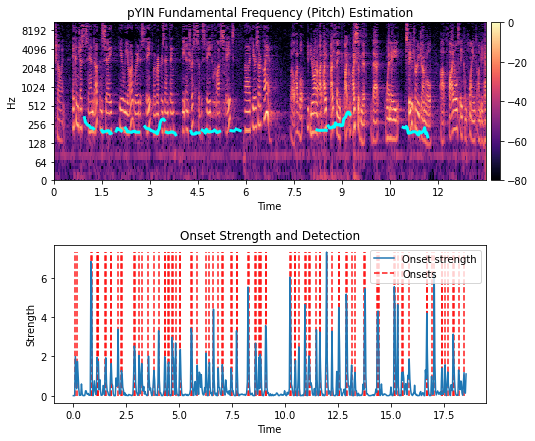

In [19]:
# Pitch
f0, voiced_flag, voiced_probs = librosa.pyin(
    clip, fmin=librosa.note_to_hz("C2"), fmax=librosa.note_to_hz("C5")
)
times = librosa.times_like(f0)
D = librosa.amplitude_to_db(np.abs(librosa.stft(clip)), ref=np.max)

# Onset
o_env = librosa.onset.onset_strength(clip, sr=wav_sr, max_size=10)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=wav_sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=wav_sr)


# Plot
D = np.abs(librosa.stft(clip))


fig = plt.figure(figsize=(8, 7))
ax1 = plt.subplot(111)
im1 = librosa.display.specshow(
    librosa.amplitude_to_db(D, ref=np.max),
    x_axis="time",
    y_axis="log",
    ax=ax1,
    label="_nolegend_",
)
ax1.set(title="pYIN Fundamental Frequency (Pitch) Estimation")
(f0_plot,) = ax1.plot(times, f0, color="cyan", label="f0 (Pitch)", linewidth=3)
# ax1.legend(handles=[f0_plot])

divider = make_axes_locatable(ax1)
ax2 = divider.append_axes("bottom", size="100%", pad=0.9)
cax = divider.append_axes("right", size="2%", pad=0.08)
cb = plt.colorbar(im1, ax=ax1, cax=cax)

ax2.set(xlabel="Time", ylabel="Strength", title="Onset Strength and Detection")
ax2.plot(times, o_env, label="Onset strength")
ax2.vlines(
    times[onset_frames],
    0,
    o_env.max(),
    color="r",
    alpha=0.9,
    linestyle="--",
    label="Onsets",
)
ax2.legend()